In [2]:
# import sys
# sys.path.append("/Users/uchihashi_k/anaconda/lib/python2.7/site-packages")
%pylab inline
%matplotlib inline  
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import six
project_path = os.getcwd() + '/../'
sys.path.append(project_path + "utils")

import sklearn.metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.grid_search import GridSearchCV
import sklearn
from sklearn.externals import joblib
from scipy.spatial.distance import euclidean

from fastdtw import fastdtw

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import seaborn as sns

In [4]:
import function
import preprocessing
import local_bayes
import visualize
import metrics
import analysis

In [5]:
sys.path.append(project_path + "models/cnn")
import cnn

# data load

In [6]:
save_data_dir = '../data/bookmark/'
train_0_0 = numpy.load(save_data_dir + '0_test/0_fold/0_train.npz')
test_0_0 = numpy.load(save_data_dir + '0_test/0_fold/0_test.npz')

# learner analysis

In [8]:
localbayes = local_bayes.LocalBayes(nn_num=20, data_dim=30, max_dist=50)
analyze = analysis.Analysis()
visual = visualize.Visualize()

## Gradient Boosting Decision Tree

In [9]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

### model fit

In [10]:
max_depth = 4
n_estimators = 5000

In [11]:
# bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=4),
#                          algorithm="SAMME",
#                          n_estimators=5000)

In [12]:
# bdt.fit(train_0_0['x'], train_0_0['y'])

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(compute_importances=None, criterion='gini',
            max_depth=4, max_features=None, max_leaf_nodes=None,
            min_density=None, min_samples_leaf=1, min_samples_split=2,
            random_state=None, splitter='best'),
          learning_rate=1.0, n_estimators=5000, random_state=None)

In [14]:
joblib.dump(bdt, '../models/gbdt/results/bdt_%s_%s.pkl' % (max_depth, n_estimators)) 

['../models/gbdt/results/bdt_4_5000.pkl',
 '../models/gbdt/results/bdt_4_5000.pkl_01.npy',
 '../models/gbdt/results/bdt_4_5000.pkl_02.npy',
 '../models/gbdt/results/bdt_4_5000.pkl_03.npy',
 '../models/gbdt/results/bdt_4_5000.pkl_04.npy',
 '../models/gbdt/results/bdt_4_5000.pkl_05.npy',
 '../models/gbdt/results/bdt_4_5000.pkl_06.npy',
 '../models/gbdt/results/bdt_4_5000.pkl_07.npy',
 '../models/gbdt/results/bdt_4_5000.pkl_08.npy',
 '../models/gbdt/results/bdt_4_5000.pkl_09.npy',
 '../models/gbdt/results/bdt_4_5000.pkl_10.npy',
 '../models/gbdt/results/bdt_4_5000.pkl_11.npy',
 '../models/gbdt/results/bdt_4_5000.pkl_12.npy',
 '../models/gbdt/results/bdt_4_5000.pkl_13.npy',
 '../models/gbdt/results/bdt_4_5000.pkl_14.npy',
 '../models/gbdt/results/bdt_4_5000.pkl_15.npy',
 '../models/gbdt/results/bdt_4_5000.pkl_16.npy',
 '../models/gbdt/results/bdt_4_5000.pkl_17.npy',
 '../models/gbdt/results/bdt_4_5000.pkl_18.npy',
 '../models/gbdt/results/bdt_4_5000.pkl_19.npy',
 '../models/gbdt/results/bd

### model load

In [15]:
bdt = joblib.load('../models/gbdt/results/bdt_%s_%s.pkl' % (max_depth, n_estimators))

#### sample prediction

In [16]:
pred_proba = bdt.predict_proba(test_0_0['x'])
pred_proba[0:10]

array([[ 0.49693204,  0.50306796],
       [ 0.4953315 ,  0.5046685 ],
       [ 0.50024175,  0.49975825],
       [ 0.49792115,  0.50207885],
       [ 0.50544236,  0.49455764],
       [ 0.49830046,  0.50169954],
       [ 0.4964708 ,  0.5035292 ],
       [ 0.52633515,  0.47366485],
       [ 0.52792237,  0.47207763],
       [ 0.51976234,  0.48023766]])

#### answer

In [17]:
test_0_0['y'][0:10]

array([1, 1, 1, 1, 0, 1, 1, 0, 0, 0])

### miss pattern

In [19]:
gbdt_pattern_x, gbdt_pattern_y, gbdt_pattern_ind = analyze.find_pattern(test_0_0['x'], test_0_0['y'], pred_proba)

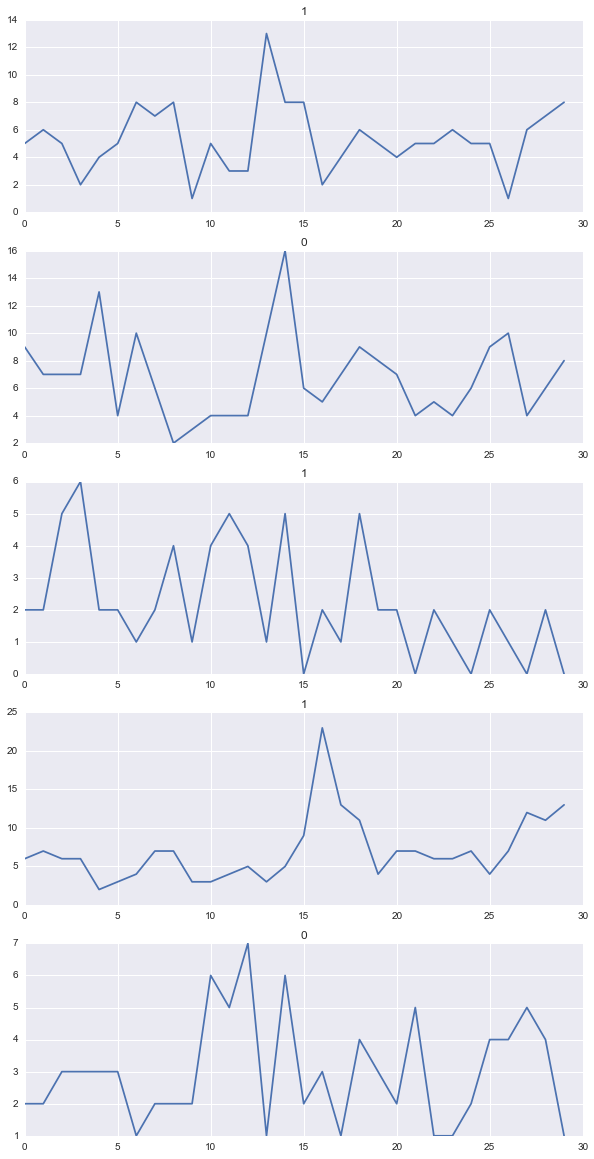

In [20]:
plt.figure(figsize=(10, 4*5), dpi=1000)
for i in xrange(5):
    plt.subplot(5, 1, i + 1)
    plt.plot(gbdt_pattern_x[i])
    plt.title('%s' % gbdt_pattern_y[i])

### correct pattern

In [21]:
gbdt_correct_x, gbdt_correct_y, gbdt_pattern_ind = analyze.find_pattern(test_0_0['x'], test_0_0['y'], pred_proba, type="correct")

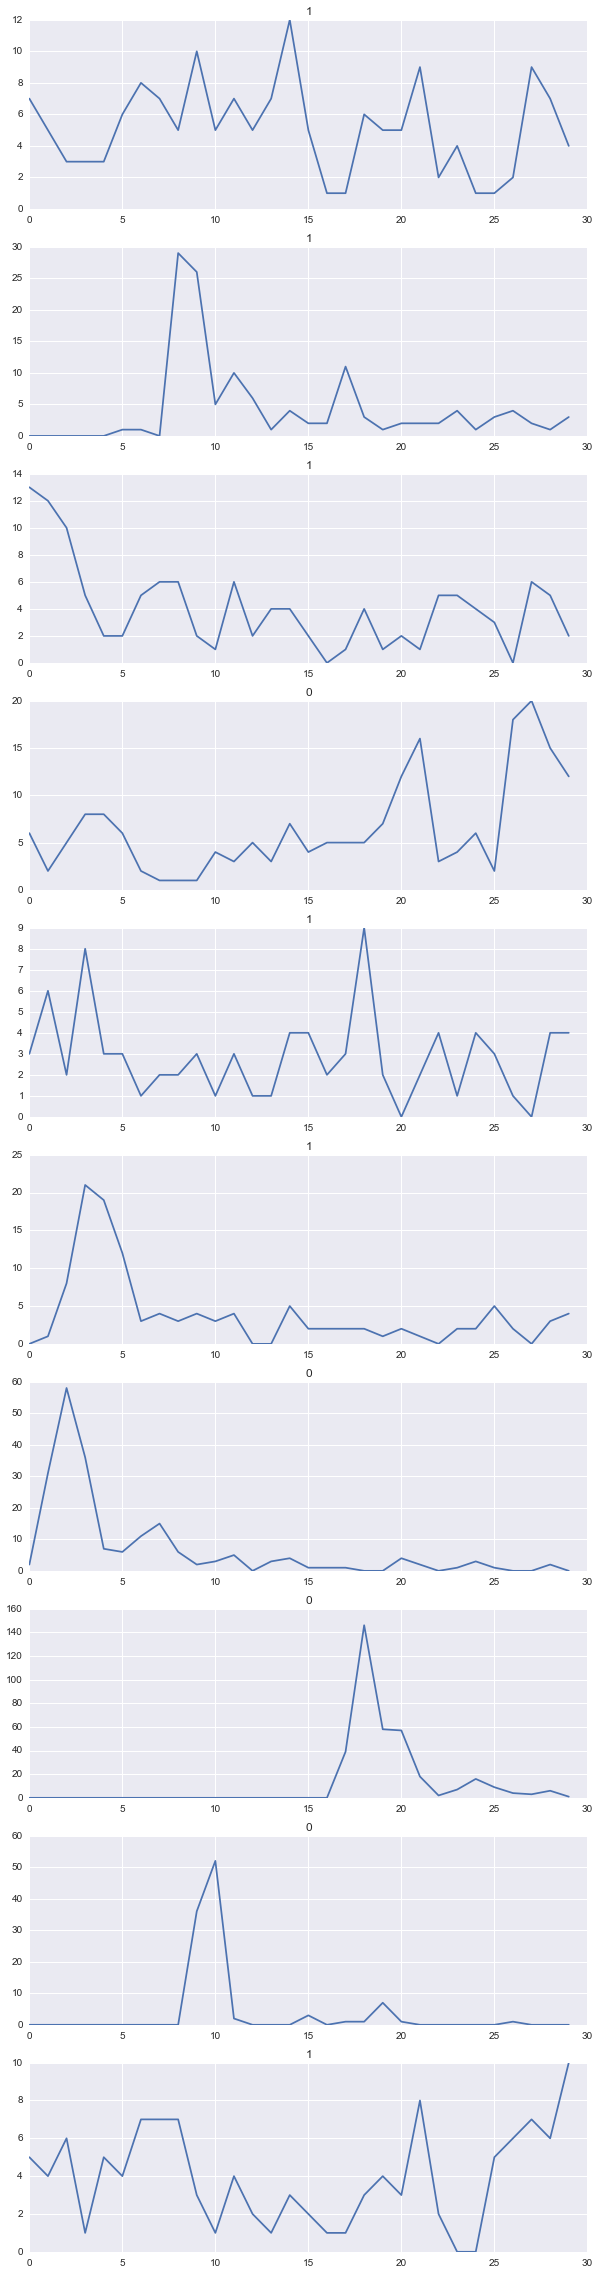

In [22]:
plt.figure(figsize=(10, 4*10), dpi=1000)
for i in xrange(10):
    plt.subplot(10, 1, i + 1)
    plt.plot(gbdt_correct_x[i])
    plt.title('%s' % gbdt_correct_y[i])

### ROC curve and AUC

In [23]:
test_score = bdt.decision_function(test_0_0['x'])

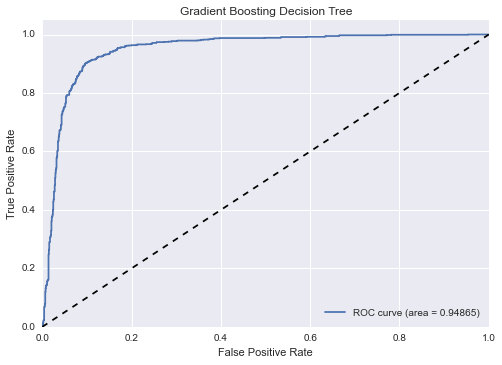

In [24]:
visual.roc_curve('Gradient Boosting Decision Tree', test_0_0, test_score)

## CNN

In [25]:
import chainer
import chainer.functions as F
import chainer.links as L
from chainer import cuda
from chainer import optimizers
from chainer import serializers
from chainer import Link, Chain, ChainList

import pandas as pd
from ggplot import *

In [26]:
save_model_dir = '../models/cnn/results/awesome_100/'

In [27]:
sys.path.append(project_path + "models/cnn")
import cnn_net

## model load

In [28]:
cnnnet = cnn_net.tsCNN_net(30)

In [29]:
model = L.Classifier(cnnnet)

In [30]:
serializers.load_npz(save_model_dir + "mlp.model", model)

## prediction

In [31]:
N_test = test_0_0['x'].shape[0]
data_dim = test_0_0['x'].shape[1]

In [32]:
def forward(x_data, model):
    x = chainer.Variable(x_data)
    h = F.max_pooling_2d(F.relu(model.conv1(x)), 2)
    h = F.max_pooling_2d(F.relu(model.conv2(h)), 2)
    h = F.relu(model.l1(h))
    y = model.l2(h)

    return y

In [33]:
test_0_0['x'].shape

(2378, 30)

In [34]:
X_test = test_0_0['x'].reshape((N_test, 1, 1, data_dim))
y_test = test_0_0['y']
pred_ = []
for i in range(0, N_test):
    x = np.asarray(X_test[i]).reshape((1, 1, 1, data_dim)).astype(numpy.float32)
    y = np.asarray(y_test[i]).astype(numpy.int32)
    
    pred = F.softmax(model.predictor(chainer.Variable(x)))
    pred_.append(pred.data[0][1])

#### sample prediction

In [35]:
pred_[0:10]

[0.99964106,
 0.99931741,
 0.98983651,
 0.99138194,
 0.005647609,
 0.95814931,
 0.99997318,
 1.5236495e-07,
 3.951946e-12,
 4.4065305e-26]

#### sample answer

In [36]:
y_test[0:10]

array([1, 1, 1, 1, 0, 1, 1, 0, 0, 0])

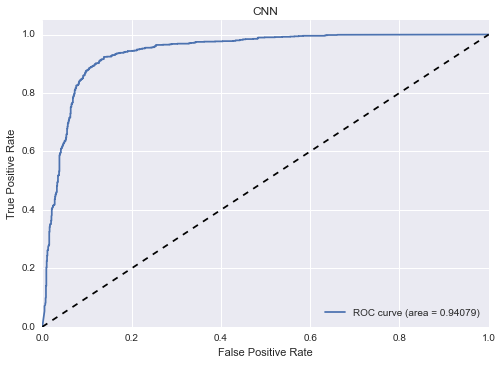

In [37]:
visual.roc_curve('CNN', test_0_0, numpy.array(pred_))

## 他カテゴリのデータでの精度を検証